In [1]:
import os
import pygplates
import time as tme
import numpy as np
import pyvista as pv
from numba import jit
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from CodeAfterFirstNotebook import Earth

In the previous notebook, we discussed how to move tectonic plates along a spherical earth. We will now discuss how we approximate various tectonic phenomina onto the earth, which will involve getting the distance and speeds that vertices are from the plate boundaries.

# Plate Boundaries

In calculating various tectonic forces, we will be needing data about various types of plate boundaries. We create a general *PlateBoundary* class, and two child-classes *SubductionBoundary* and *RidgeBoundary*. To initiate plate boundary, we will pass the *sharedBound* object obtained from the *pygplates* library, which reconstructs coordinates and other properties about plate boundaries.

The attribute *sharedPlateIds* contains the plate ids of neighbouring plates for each point on the plate boundary. In most cases, *pygplates* provides two plates as the neighbouring plates, however occasionally it will provide a different number of neighbouring plates. If *pygplates* doesn't provide exactly two neighbouring plates, then we will not include that particular plate boundary section, as it will only cause problems in our code later on.

In [2]:
#Define a few directory locations and other parameters
mainDirectory = os.path.dirname(os.path.dirname(os.path.abspath('')))
platePolygonsDirectory = mainDirectory + '/dataPygplates/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies_PMAG.gpmlz'
rotationsDirectory = mainDirectory + '/dataPygplates/Matthews_etal_GPC_2016_410-0Ma_GK07_PMAG.rot'
rotationModel = pygplates.RotationModel(rotationsDirectory)
earthRadius = 6378.137
time = 0

#Create a general plate boundary class
class PlateBoundary:
    def __init__(self, sharedBound):
        
        #Extract relevant data from sharedBounds
        lon, lat, sharedPlateIds = [], [], []
        for sharedSubSection in sharedBound.get_shared_sub_segments():
            latLon = sharedSubSection.get_resolved_geometry().to_lat_lon_array()
            
            #Get ids of neighbouring plates
            sharedId = []
            for i in sharedSubSection.get_sharing_resolved_topologies():
                idx = i.get_resolved_feature().get_reconstruction_plate_id()
                sharedId.append(idx)
            
            #Ignore plate boundaries with not exactly two neighbouring plates
            twoSharedIds =  (len(sharedId) == 2)
            if not twoSharedIds:
                continue
            
            #Append relevant data to lists
            for i in range(len(latLon)):
                lon.append(latLon[i, 1])
                lat.append(latLon[i, 0])
                sharedPlateIds.append(sharedId)
        
        #Store data as class attributes
        self.lon = np.array(lon)
        self.lat = np.array(lat)
        self.XYZ = Earth.polarToCartesian(earthRadius, self.lon, self.lat)
        self.sharedPlateIds = np.array(sharedPlateIds)
        self.boundType = 0
        self.gpmlBoundType = str(sharedBound.get_feature().get_feature_type())
        
        #These attributes will be set later
        self.lineCentres = np.zeros((self.XYZ.shape[0] - 1, 3))
        self.linePoints = np.zeros((self.XYZ.shape[0] - 1, 2, 3))
        self.collisionSpeed = np.zeros(self.XYZ.shape[0] - 1)
        self.speedDirection = np.zeros((self.XYZ.shape[0] - 1, 3))

#Create child class for subduction plate boundaries
class SubductionBoundary(PlateBoundary):
    def __init__(self, sharedBound):
        
        #Run the parent's initialization
        PlateBoundary.__init__(self, sharedBound)
        
        #Get plate ids of overriding plate and subducting plates
        overPlateId, subPlateId = [], []
        for sharedSubSection in sharedBound.get_shared_sub_segments():
            overAndSubPlates = sharedSubSection.get_overriding_and_subducting_plates(True)
            if (overAndSubPlates != None):
                overridingPlate, subductingPlate, subduction_polarity = overAndSubPlates
                overPlateId.append(overridingPlate.get_feature().get_reconstruction_plate_id())
                subPlateId.append(subductingPlate.get_feature().get_reconstruction_plate_id())
        
        #Save data
        self.overPateId = np.unique(overPlateId)
        self.subPlateId = np.unique(subPlateId)
        self.boundType = 1

#Create child class for ridge plate boundaries
class RidgeBoundary(PlateBoundary):
    def __init__(self, sharedBound):
        PlateBoundary.__init__(self, sharedBound)
        self.boundType = 2

Now that we have defined our classes, we create a function that makes use of *pygplates* to return a list of plate boundary objects at a specified time.

In [3]:
#Since we are ignoring plate boundaries with not exactly two neighbouring plates,
#Some plate boundaries will have no coordinates, so we ignore those
def ignoreThisBoundary(sharedBound):
    ignoreThis = True
    for s in sharedBound.get_shared_sub_segments():
        if len(s.get_sharing_resolved_topologies()) == 2:
            ignoreThis = False
    return ignoreThis

#Create function that returns a list of plate boundaries at specified times
def createPlateBoundariesAtTime(time, platePolygonsDirectory=None, rotationsDirectory=None):
    if platePolygonsDirectory == None:
        platePolygonsDirectory = mainDirectory + '/dataPygplates/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies_PMAG.gpmlz'
    if rotationsDirectory == None:
        rotationsDirectory = mainDirectory + '/dataPygplates/Matthews_etal_GPC_2016_410-0Ma_GK07_PMAG.rot'
    
    #Use pygplates to get shared boundary sections at specified time
    resolvedTopologies, sharedBoundarySections = [], []
    rotationModel = pygplates.RotationModel(rotationsDirectory)
    pygplates.resolve_topologies(platePolygonsDirectory, rotationModel, resolvedTopologies, time, sharedBoundarySections)
    
    #Loop through all shared plate boundaries
    plateBoundaries = []
    for sharedBound in sharedBoundarySections:

        #Identify which type of boundary this is
        boundType = sharedBound.get_feature().get_feature_type()
        isSubduction = boundType == pygplates.FeatureType.gpml_subduction_zone
        isOceanicRidge = boundType == pygplates.FeatureType.gpml_mid_ocean_ridge
        if ignoreThisBoundary(sharedBound):
            continue

        #Create plate boundary object of appropriate type and append to list of plate boundaries
        if isSubduction:
            plateBoundaries.append(SubductionBoundary(sharedBound))
        elif isOceanicRidge:
            plateBoundaries.append(RidgeBoundary(sharedBound))
        else:
            plateBoundaries.append(PlateBoundary(sharedBound))
            
    return plateBoundaries

The following function will be used for converting a list of plate boundary objects into a *pyvista* mesh of lines for better visualizations of the plate boundaries.

In [4]:
def getBoundaryLines(plateBounds):
    
    #Variables used to create the line pyvista object
    XYZ, lineConnectivity, bType = [], [], []
    
    #Counter for keeping track of how many vertices we have used
    xyzCount = 0
    
    #Loop through all plate boundaries
    for bound in plateBounds:
        
        #Create lineID for defining line connectivity
        numOfPoints = len(bound.XYZ)
        lineConnectivity.append(numOfPoints)
        lineID = np.arange(numOfPoints) + xyzCount
        
        #Loop through points in plate boundary and append to arrays
        for i in range(numOfPoints):
            lineConnectivity.append(lineID[i])
            XYZ.append(bound.XYZ[i])
            bType.append(bound.boundType)
        xyzCount += numOfPoints
        
    #Create the line mesh
    lineMesh = pv.PolyData(np.array(XYZ), lines=lineConnectivity)
    lineMesh['boundType'] = np.array(bType)
    return lineMesh

#Create mesh object for plotting
pBounds = createPlateBoundariesAtTime(10)
lineMesh = getBoundaryLines(pBounds)

#Plot the results
plotter = pv.PlotterITK()
plotter.add_mesh(pv.Sphere(radius=earthRadius-100))
plotter.add_mesh(lineMesh, scalars='boundType')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Distance from Plate Boundaries

To apply various tectonic forces, we will need to know how far a vertex is from plate boundaries. A simple yet naiive solution would be to use the *scipy.spatial.cKDTree()* function to get the distances from sphere points to boundary points. Although this approach works well for sphere points which are fairly far from plate boundaries, it does not work well for points near the boundary regions, as demonstrated bellow. 

What we want to do instead, is to measure the distance from the line spanned by two boundary points.

In [5]:
#Create a sphere
sphere = pv.Sphere(radius=earthRadius, theta_resolution=400, phi_resolution=400)
sphereXYZ = sphere.points

#Create plate boundaries and get its XYZ coordinates
plateBounds = createPlateBoundariesAtTime(0)
boundMesh = getBoundaryLines(plateBounds)
boundXYZ = boundMesh.points

#Calculate distances from points
distances = cKDTree(boundXYZ).query(sphereXYZ)[0]

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(sphere, scalars=distances**0.25)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

We will now explain how we calculate a distance from a line with reference to the image bellow. Let $\textbf{s}$ be a point on the sphere, $\textbf{p}_1$ and $\textbf{p}_2$ be the two points spanning the boundary segments. In calculate the distance of $\textbf{s}$ from the line segment, there are 3 possible cases:

 - $\textbf{s}$ is closest to $\textbf{p}_1$
 - $\textbf{s}$ is closest to some point between $\textbf{p}_1$ and $\textbf{p}_2$
 - $\textbf{s}$ is closest to $\textbf{p}_2$
 
Let $\textbf{v} = \textbf{p}_2 - \textbf{p}_1$ and $\textbf{w} = \textbf{s} - \textbf{p}_1$, then we can check which case we are in with:

- Case 3: $\textbf{w} \cdot \textbf{v} <= 0$
- Case 1: If not case 3 and $\textbf{v} \cdot \textbf{v} <= \textbf{w} \cdot \textbf{v}$
- Case 2: Otherwise

Incase the reader may be unfamiliar with the dot product, taking the dot product of a vector with $\textbf{v}$ gives the magnitude of the projection of the vector onto $\textbf{v}$. Once we have identified which case we are in, we can make the appropriate distance calculation.

<div>
<img src="files/Images/ClosestToLineCropped2.png" width="600">
</div>

We split this task into 3 function and *getDistsToBounds()* will be the main function we call. It will use *prepareLines()* to get the centres and the points $\textbf{p}_1$ and $\textbf{p}_2$. We use *cKDTree()* to get the index of the closest line centres for each point on the sphere, which can be used to get the appropriate $\textbf{p}_1$ and $\textbf{p}_2$. We then use *getDistsToLinesSeg()* to calculate the appropriate distance as explained above. 

Since the function *getDistsToLinesSeg()* is slow, we use the *@jit(nopython=True)* decorator from the *numba* library to significantly speed things up. Although this decorator poses many restrictions on the content of the function such that we can not use many libraries apart from numpy, it speeds up our calculation by 10 times the speed. It is also a good habit to get into since it allows for GPU acceleration and can sometimes speed python code by 1000 times. If *numba* is not installed in your system, just uncomment the decorator and the function should run as normal, but slower.

In [6]:
#Get line centres and points spanning each line
def prepareLines(plateBounds):
    lineCentres, linePoints = [], []
    for bound in plateBounds:
        for i in range(bound.XYZ.shape[0]-1):
            point1 = bound.XYZ[i]
            point2 = bound.XYZ[i+1]
            lineCentres.append((point1 + point2) / 2)
            linePoints.append([point1, point2])
    return np.array(lineCentres), np.array(linePoints)

#Get distance from line segments
@jit(nopython=True)
def getDistsToLinesSeg(sphereXYZ, closestLinePoints):
    distToBound = np.zeros(sphereXYZ.shape[0])
    for i in range(sphereXYZ.shape[0]):
        linePoints = closestLinePoints[i]
        xyz = sphereXYZ[i]

        #Append distance from vertex 0
        v = linePoints[1] - linePoints[0]
        w = xyz - linePoints[0]
        if np.dot(w, v) <= 0:
            distToZero = np.linalg.norm(linePoints[0] - xyz)
            distToBound[i] = distToZero

        #Append distance from vertex 1  
        elif np.dot(v, v) <= np.dot(w, v):
            distToOne = np.linalg.norm(linePoints[1] - xyz)
            distToBound[i] = distToOne

        #Append distance from somewhere in the line centre
        else:
            numerator = np.linalg.norm(np.cross(linePoints[1] - xyz, linePoints[1] - linePoints[0]))
            denominator = np.linalg.norm(linePoints[1] - linePoints[0])
            distToLine = numerator / denominator
            distToBound[i] = distToLine
    return distToBound

#Main function to call to get distance from plate boundaries
def getDistsToBounds(plateBounds, sphereXYZ):
    lineCentres, linePoints = prepareLines(plateBounds)
    distIds = cKDTree(lineCentres).query(sphereXYZ)[1]
    closestLinePoints = linePoints[distIds]
    distToBound = getDistsToLinesSeg(sphereXYZ, closestLinePoints)
    return distToBound

As we can see bellow, we now have much cleaner distances to plate boundaries.

In [7]:
#Run the newly defined functions
distToBound = getDistsToBounds(plateBounds, sphereXYZ)

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(sphere, scalars=distToBound**0.25)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Speed of Collision

In order to approximate forces such as subduction uplift or ocean floor formation, we will require the speed at which plates converge or diverge. We will use positive speeds to represent converging plate boundaries and negative speeds to represent diverging plate boundaries. We will use the term *velocity* in the context of vectors (direction and magnitude) and *speed* as only the magnitude of the velocity.

Velocity$\textbf{v}$ is defined as the rate of change in position $\textbf{x}$, given by:

$$
\textbf{v} = \frac{\delta \textbf{x}}{\delta t}
$$

Here $\delta t$ is the chage in time and $\delta \textbf{x}$ is the change in position at each iteration of our simulation. To calculate $\delta \textbf{x}$ for any point $\textbf{x}$ on a plate boundary, we apply rotations $r_0$ and $r_1$ on $\textbf{x}$ from plates on either sides of the plate boundary, and the change in position can be calculated by:

$$
\delta \textbf{x} = r_1(\textbf{x}) - r_0(\textbf{x})
$$

The speed $s$ can then be obtained by taking the vector norm of the velocit $\| \textbf{v} \|$.

$$
\| \textbf{v} \| = \Big\| \frac{r_1(\textbf{x}) - r_0(\textbf{x})}{\delta t} \Big\|
$$

To assign each speed a positive or negative coefficient representing convergence or divergence, we apply rotations $r_0$ and $r_1$ to the plate centres $\textbf{c}_0$ and $\textbf{c}_1$ of plates on either sides of the boundary, and see if they moved closer or further away from each other. In other words, we set the speed to negative if:

$$
\| \textbf{c}_1 - \textbf{c}_0 \| < \| r_1(\textbf{c}_1) - r_0(\textbf{c}_0) \|
$$

The plate centres are calculated as the average position of all vertices belonging on that plate. To identify which plates bellong to either sides of a plate boundary, we refer to the attribute *sharedPlateIds*. These IDs can then be used to get the appropriate rotations $r_0$ and $r_1$.

In [8]:
#Create a dictionary containing plate Ids as keys and plate centres as values
def getPlateCentres(sphereXYZ, plateIds):
    plateCentres = {}
    uniqueIds = np.unique(plateIds)
    for i in range(uniqueIds.shape[0]):
        plateXYZ = sphereXYZ[plateIds==uniqueIds[i]]# * earthRadius
        plateCentres[uniqueIds[i]] = np.sum(plateXYZ, axis=0) / plateXYZ.shape[0]
    return plateCentres

#Calculate the speed of collisions
def getCollisionsSpeeds(boundXYZ, sharedPlateIds, rotations, plateCentres, deltaTime):
    speeds = np.zeros(boundXYZ.shape[0])
    directions = np.zeros((boundXYZ.shape[0], 3))
    speedDirection = np.zeros((boundXYZ.shape[0], 3))
    for i in range(boundXYZ.shape[0]):
        bXYZ = boundXYZ[i]
        shareId = sharedPlateIds[i]
        
        #Some tectonic plates are so small that we don't have any vertices representing it
        #Therefore, some sharedIds might not have rotations or plate centres defined for it
        #In this case we simply set the speed to 0 and ignore the rest of this function
        if not np.all(np.isin(shareId, list(rotations.keys()))):
            continue
        
        #Calculate speed based on distance moved by rotations
        rot0 = rotations[shareId[0]]
        rot1 = rotations[shareId[1]]
        movedXyz0 = rot0.apply(bXYZ)
        movedXyz1 = rot1.apply(bXYZ)
        velocity = (movedXyz1 - movedXyz0) / deltaTime
        speed = np.linalg.norm(velocity)
        if speed != 0:
            directions[i] = velocity / speed
        
        #Identify if this boundary segment belongs to a converging or diverging boundary
        #Then set speed to positive or negative value accordingly
        cent0 = plateCentres[shareId[0]]
        cent1 = plateCentres[shareId[1]]
        centDist = np.linalg.norm(cent1 - cent0)
        centDistAfter = np.linalg.norm(rot1.apply(cent1) - rot0.apply(cent0))
        if centDist < centDistAfter:
            speed = -speed
        speeds[i] = speed
    return speeds, directions

We save collision speeds, directions and others as plate boundary object attributes. This way, whenever we find the closest plate bound for a given vertex on our sphere, we can easily obtain the corresponding attributes bellonging to that plate boundary object. We then define a function that returns speed related data given a list of plate boundary objects. The purpose of some of the speed related data will make more sense later in this notebook.

In [9]:
#We set the collision speed attribute for points in our plate boundary objects
def setCollisionSpeeds(plateBounds, rotations, plateCentres, deltaTime):
    for bound in plateBounds:
        for i in range(bound.XYZ.shape[0]-1):
            point1 = bound.XYZ[i]
            point2 = bound.XYZ[i+1]
            bound.lineCentres[i] = (point1 + point2) / 2
            bound.linePoints[i, 0] = point1
            bound.linePoints[i, 1] = point2
        speeds, directions = getCollisionsSpeeds(
            bound.lineCentres, 
            bound.sharedPlateIds[:-1], 
            rotations, 
            plateCentres, 
            deltaTime)
        bound.collisionSpeed = speeds
        bound.speedDirection = directions
    return plateBounds

#Given a list of subduction boundaries, we extract relevant data and return as arrays
def getSpeedsData(subBounds):
    boundXYZ, boundSpeed, boundDirection, linePoints = [], [], [], []
    for bound in subBounds:
        for i in range(bound.lineCentres.shape[0]):
            boundXYZ.append(bound.lineCentres[i])
            boundSpeed.append(bound.collisionSpeed[i])
            boundDirection.append(bound.speedDirection[i])
            linePoints.append(bound.linePoints[i])
    boundSpeed = np.array(boundSpeed)
    boundSpeed[boundSpeed < 0] = 0
    linePoints = np.array(linePoints)
    lineLengths = np.linalg.norm(linePoints[:, 0, :] - linePoints[:, 1, :], axis=1)
    return np.array(boundXYZ), boundSpeed, np.array(boundDirection), linePoints, lineLengths

The following functions are used for creating *pyvista* mesh objects for plotting purposes.

In [10]:
#Create pyvista mesh objects for plotting
def getSpeedsMesh(boundCentXYZ, speeds, scale=600):
    arrow = pv.Arrow(start=(-0.5, 0.0, 0.0))
    boundMesh = pv.PolyData(boundCentXYZ * 1.05)
    boundMesh['direction'] = boundCentXYZ
    boundMesh['size'] = speeds / np.max(speeds)
    speedVectors = boundMesh.glyph(geom=arrow, orient='direction', scale='size', factor=scale)
    return speedVectors

#Create mesh object for visualizing the direction of collisions
def getSpeedDirectionsMesh(boundCentXYZ, directions, scale=300):
    cylinder = pv.Cylinder(radius=0.02)
    boundMesh = pv.PolyData(boundCentXYZ * 1.05)
    boundMesh['direction'] = directions
    directionMesh = boundMesh.glyph(geom=cylinder, orient='direction', factor=scale)
    return directionMesh

We run the newly created functions and visualize the results. Arrows pointing away from the sphere represent converging boundaries, and arrows pointing downwards represent diverging boundaries. The collision direction is represented by lines (thin cylinders) oriented in the collision directions.

We make use of code discussed in the previous notebook to get earth related data, which are required for our speed calculations. These include plateIds, rotations, topography and various others.

In [11]:
#Specify the date to consider for our data
time = 5 #Million Years Ago

#Use the imported code based on the previous tutorial to get relevant earth data
earth = Earth(startTime=time)
plateIds = earth.getPlateIdsAtTime(time)
rotations = earth.getRotations(plateIds, time)
sphereXYZ = earth.sphereXYZ# * earth.earthRadius
plateCentres = getPlateCentres(sphereXYZ, plateIds)

#Calculate collisions speeds
plateBounds = createPlateBoundariesAtTime(time)
plateBounds = setCollisionSpeeds(plateBounds, rotations, plateCentres, earth.deltaTime)
boundCentXYZ, speeds, directions, linePoints, lineLengths = getSpeedsData(plateBounds)

#Create mesh objects for plotting
speedMesh = getSpeedsMesh(boundCentXYZ, speeds)
directionMesh = getSpeedDirectionsMesh(boundCentXYZ, directions)
exageratedRadius = 30 * earth.heightHistory[0] + earth.earthRadius
earthMesh = pv.PolyData((earth.sphereXYZ.T * exageratedRadius).T, earth.earthFaces)

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=earth.heightHistory[0])
plotter.add_mesh(speedMesh)
plotter.add_mesh(directionMesh)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Subduction Uplift

When two tectonic plates collide, one will typically submerge underneath the other, pushing the overriding plate upwards which leads to mountain growth. The class *SubductionBoundary* contains lists of overriding and subducting plates IDs which can be used to identify which plate to apply subduction uplift onto, corresponding to overriding plates.

To approximate the change in height $\delta h$ we apply to overriding vertices, we will consider:

- $f(d, \theta)$: The distance $d$ an overriding vertex is from the subduction boundary, and the angle $\theta$ that a vertex makes with the direction of collision.
- $g(s, \theta)$: The speed $s$ at which nearby subduction boundaries are colliding with, and the angle $\theta$.
- $h(r_h)$: The current height $r_h$ of the vertex

We will refer to each contribution as f, g, and h the distance, speed and height transfers.

Note that for simplification purposes, we will treat orogenic belts (continental collision) as a subduction boundary where both sides of the boundary are considered to be overriding plates.

### Distance Transfer

To create the distance transfer $f(d)$, we will create a list template points to draw the distance transfer from. We will then use the quadratic 1 dimensional interpolation scheme *scipy.interpolate.interp1d()* to convert these points into a continuous function. When specifying these template points, the main features of the function should be kept within a range of $d$ and $f \in [0, 1]$, so that the effective range of the distance transfer can be specified by $\alpha$, which can be applied by using $f(\frac{d}{\alpha})$. 

Note that we will also be passing distances to $f(\frac{d}{\alpha})$ which fall outside the range of $[0, 1]$. To avoid crashing the *interp1d()* function, we will return 0 for those values. Also, since *interp1d()* fits a quadratic polynomial to the template points, we need to confirm that the resulting polynomial looks as desired by plotting it, otherwise we may get unexpected swings in the template curve.

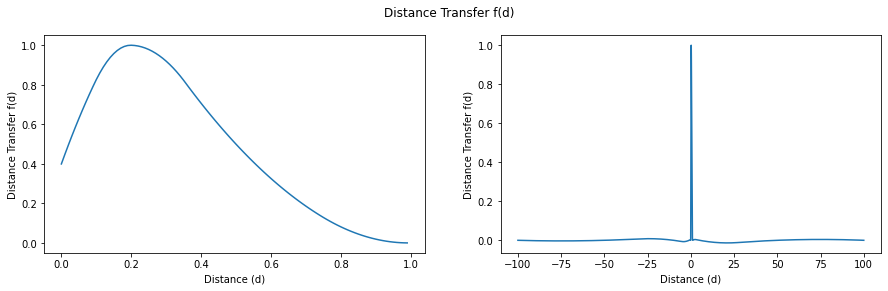

In [12]:
#Template curve for the distance transfer for subduction uplift
distTransPoints = np.array([
    [-100, 0.0],
    [-50, 0],
    [-10, 0],
    [-1.0, 0.0],
    [-0.101, 0.0],
    [-0.1, 0.0],
    [0, 0.4],
    [0.19, 1.0],
    [0.21, 1.0],
    [0.5, 0.5],
    [0.99, 0.0],
    [1.0, 0.0],
    [5.0, 0.0],
    [50.0, 0.0],
    [100.0, 0.0]
    ])
distanceTransfer = interp1d(distTransPoints[:, 0], distTransPoints[:, 1], kind='quadratic')

fig, axs = plt.subplots(1, 2, figsize=(15,4))
fig.suptitle('Distance Transfer f(d)')

d = np.arange(0, 1, 0.01)
f = distanceTransfer(d)
axs[0].plot(d, f)
axs[0].set(xlabel='Distance (d)', ylabel='Distance Transfer f(d)')

d = np.arange(-100, 100, 0.01)
f = distanceTransfer(d)
axs[1].plot(d, f)
axs[1].set(xlabel='Distance (d)', ylabel='Distance Transfer f(d)')
plt.show()

For the sake of subduction uplift, we only want to measure distances from vertices to the subduction boundaries where this plate is overriding on. In other words, for a given plate, we don't want to measure distances to boundaries where this plate is subducting. To achieve this, we create a dictionay that has plateIds as keys, and returns the appropriate plateBoundary objects. We then loop through each plate Id on our earth, and use the dictionary to calculate distance from the appropriate plate boundaries.

In [13]:
#Create dictionary with plate ids as keys and the plate's subduction boundary as values
def getSubductionBoundsForEachPlateId(plateBounds):
    idToSubBound = {}
    for bound in plateBounds:
        
        #List to store plate ids of overriding plates for this boundary
        overId = []
        
        #Append plate ids of overiding plates
        if bound.boundType == 1:
            for idx in bound.overPateId:
                overId.append(idx)
        
        #Append plate ids of both sides of an orogenic belt
        elif bound.gpmlBoundType == 'gpml:OrogenicBelt':
            for sIds in bound.sharedPlateIds:
                for idx in sIds:
                    overId.append(idx)
        
        #We append this plate boundary to dictionary values with appropriate keys (plateIds)
        overId = np.unique(overId)
        for idx in overId:
            if (idx not in list(idToSubBound.keys())):
                idToSubBound[idx] = []
            idToSubBound[idx].append(bound)
    return idToSubBound

#Using this dictionary, we can now measure the appropriate distances
#The default distance will be zero
def getDistanceToSubductionBoundary(sphereXYZ, plateIds, idToSubBound):
    distToSub = np.zeros(sphereXYZ.shape[0])
    for idx in np.unique(plateIds):
        if (idx not in idToSubBound.keys()):
            continue
        
        #Get the appropriate distance for vertices on this plate
        subBounds = idToSubBound[idx]
        xyzOnThisPlate = sphereXYZ[plateIds == idx]
        dists = getDistsToBounds(subBounds, xyzOnThisPlate)
        distToSub[plateIds == idx] = dists
    return distToSub

#We provide a demonstration of the distance transfer
distTransRange = 2000
idToSubBound = getSubductionBoundsForEachPlateId(plateBounds)
distToSub = getDistanceToSubductionBoundary(sphereXYZ, plateIds, idToSubBound)
distTrans = distanceTransfer(distToSub / distTransRange)
distTrans[distToSub <= 0] = 0

#Visualise the results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=distTrans)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### Speed Transfer

A simple yet naive approach for applying the speed transfer is:
1. For each vertex on a given plate, find the closest valid subduction boundary
2. Set the speed of each vertex to that of the closest subduction boundary

However, theres a problem with this approach as demonstrated bellow. Calculating speeds in this way results in 'jumps' in the speed transfer. One region of a plate might have a single common closest subduction boundary, and a neighbouring region might have a common closest subduction boundary with a completely different speeds. At the transition of these two regions, the speed transfer will form a 'jump' in speed, which isn't realistic.

In [14]:
#Loop through each plate on our sphere
speedTrans = np.zeros(sphereXYZ.shape[0])
for idx in np.unique(plateIds):
    if (idx not in idToSubBound.keys()):
        continue
    
    #For each plate, get appropriate boundary data
    boundXYZ, boundSpeed = [], []
    for bound in idToSubBound[idx]:
        for i in range(bound.lineCentres.shape[0]):
            boundXYZ.append(bound.lineCentres[i])
            boundSpeed.append(bound.collisionSpeed[i])
    boundSpeed = np.array(boundSpeed)

    #Get the distance from vertices to plate boundaries for this plate
    xyzOnThisPlate = sphereXYZ[plateIds == idx]
    distIds = cKDTree(boundXYZ).query(xyzOnThisPlate)[1]
    speedTrans[plateIds == idx] = boundSpeed[distIds]

#Display the results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=speedTrans)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.add_mesh(speedMesh)
plotter.add_mesh(directionMesh)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

To avoid these sudden jumps in speed transfers, we will find the closest $N$ subduction boundary coordinates, and our speed transfers will be based on an average of the collisions speeds of those $N$ boundaries.

In [15]:
numToAverage = 10

#Loop through each plate on our sphere
speedTrans = np.zeros(sphereXYZ.shape[0])
for idx in np.unique(plateIds):
    if (idx not in idToSubBound.keys()):
        continue
    
    #For each plate, get appropriate boundary data
    boundXYZ, boundSpeed = [], []
    for bound in idToSubBound[idx]:
        for i in range(bound.lineCentres.shape[0]):
            boundXYZ.append(bound.lineCentres[i])
            boundSpeed.append(bound.collisionSpeed[i])
    boundSpeed = np.array(boundSpeed)

    #Get the distance from vertices to plate boundaries for this plate
    xyzOnThisPlate = sphereXYZ[plateIds == idx]
    distIds = cKDTree(boundXYZ).query(xyzOnThisPlate, k=numToAverage)[1]
    
    #Avoid 'index out of bounds error', which happens when 'numToAverage' is larger than the number of points on a boundary
    distIds[distIds >= boundSpeed.shape[0]] = boundSpeed.shape[0]-1 
    
    boundSpeed = boundSpeed[distIds]
    speedTrans[plateIds == idx] = np.sum(boundSpeed, axis=1) / numToAverage

#Display the results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=speedTrans)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.add_mesh(speedMesh)
plotter.add_mesh(directionMesh)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

The speed transfer so far does not include angle. For each $N$ closest plate boundary points, we want to calculate the angle $\theta$ between the direction of plate collision, and direction from plate boundary to a vertex on a plate. Bellow is a function that returns the direction to N nearest boundary locations for each vertex on a plate. Similarly to the distance calculations, our calculations will be split into three different cases. In case 1 and 2, we get the directions from either boundary lines to the vertex, and in case 3, this direction is perpendicular to the boundary line.

In [16]:
#Get distance from line segments
@jit(nopython=True)
def getDirectionToBound(XYZ, closestLinePoints):
    directionToBound = np.zeros((XYZ.shape[0], closestLinePoints.shape[1], 3))
    for i in range(XYZ.shape[0]):
        linePoints = closestLinePoints[i]
        xyz = XYZ[i]

        #Get v and w to identify which case we are in
        v = linePoints[:, 1] - linePoints[:, 0]
        w = xyz - linePoints[:, 0]
        
        #Loop through each point to average over (later on)
        for j in range(w.shape[0]):
            
            #Case 1
            if np.dot(w[j], v[j]) <= 0:
                direction = linePoints[j, 0] - xyz
                directionToBound[i, j] = direction / np.linalg.norm(direction)

            #Case 2  
            elif np.dot(v[j], v[j]) <= np.dot(w[j], v[j]):
                direction = linePoints[j, 1] - xyz
                directionToBound[i, j] = direction / np.linalg.norm(direction)

            #Case 3
            else:
                #direction = np.cross(xyz, linePoints[j, 1] - linePoints[j, 0])
                direction = np.cross(linePoints[j, 0], linePoints[j, 1] - linePoints[j, 0])
                directionToBound[i, j] = direction / np.linalg.norm(direction)
    return directionToBound

### Combining Speed, Angle and Distance Transfers

To get the speed and distance transfers, we will loop through each unique plate ID on the sphere in the *getTransfers()* function bellow. We then use *getTransfersForThisPlate()* to calculate some of the transfer data for each plate, and *getTransfers()* will use this data to create transfer data arrays for all points on our sphere.

The angle transfer $\cos(\theta)$ will be calculated by taking the dot product between the direction from point to boundary, and direction of this boundary's collision. Since the shape of our input arrays are not suitable for *np.dot()*, we will use *np.einsum()* instead, which apparently is also faster (according to some guy on the internet). Since both direction arrays are already normalized, the dot product will give the appropriate angle.

The speed transfers for each nearby subduction boundary, will be calculated by:

$$
g(s, \theta) = \| s \cos(\theta) \|
$$

where $s$ is the speed of boundary collision. The purpose of including $\cos(\theta)$ is to ensure that points on a plate in the direction of collision are more heavily influenced.

We also improve the distance transfer by including the angle transfer $\cos(\theta)$ in its calculation. This is done by passing the effective distance $d_{eff}$ into the distance transfer function discussed previously:

$$
f(d_{eff}) =  f \Big( \frac{d_a}{\alpha \cos(\theta)} \Big)
$$

where $d_a$ is the actual distance. This change will have make the distance transfer have a further range in the direction of collision.

In [17]:
#Calculates transfers one plate at a time
def getTransfersForThisPlate(subBounds, xyzOnThisPlate, plateIds, numToAverageOver=80):
    boundXYZ, boundSpeed, bCollisionsDirection, linePoints, lineLengths = getSpeedsData(subBounds)
    
    #Get distances and the index array distIds
    distIds = cKDTree(boundXYZ).query(xyzOnThisPlate, k=numToAverageOver)[1]
    distIds[distIds >= boundXYZ.shape[0]] = boundXYZ.shape[0]-1 #Avoid 'index out of bounds error'
    closestLinePoints = linePoints[distIds]
    distToBound = getDistsToLinesSeg(xyzOnThisPlate, closestLinePoints[:, 0])
    directionToBound = getDirectionToBound(xyzOnThisPlate, closestLinePoints)
    
    #'distIds' contains the indices of the N closest boundaries for each vertex XYZ on this plate
    boundSpds = boundSpeed[distIds]
    lineLngths = lineLengths[distIds]
    boundDirs = bCollisionsDirection[distIds]
    
    #Main transfer calculations
    speedTrans = np.zeros((numToAverageOver, xyzOnThisPlate.shape[0]))
    angleTrans = np.zeros((numToAverageOver, xyzOnThisPlate.shape[0]))
    for j in range(numToAverageOver):
        cosAngle = np.einsum('ij,ij->i', directionToBound[:, j], boundDirs[:, j]) #Dot product
        speedTrans[j] = np.abs(boundSpds[:, j] * cosAngle)# * lineLngths[:, j])
        angleTrans[j] = np.abs(cosAngle)
    return speedTrans, angleTrans, distToBound

#Calculates transfers for all plates on the sphere
def getTransfers(sphereXYZ, plateIds, idToSubBound, numToAverageOver=80, distTransRange=1000):
    speedTransfer, angleTransfer = np.zeros(sphereXYZ.shape[0]), np.zeros(sphereXYZ.shape[0])
    distToSubBounds = np.zeros(sphereXYZ.shape[0])
    for idx in np.unique(plateIds):
        if (idx not in idToSubBound.keys()):
            continue
        
        subBounds = idToSubBound[idx]
        xyzOnThisPlate = sphereXYZ[plateIds == idx]
        speedTrans, angleTrans, distToBound = getTransfersForThisPlate(subBounds, xyzOnThisPlate, plateIds, 
                                                                       numToAverageOver=numToAverageOver)
        speedTransfer[plateIds==idx] = np.sum(speedTrans, axis=0) / numToAverageOver
        angleTransfer[plateIds==idx] = np.sum(angleTrans, axis=0) / numToAverageOver
        distToSubBounds[plateIds==idx] = distToBound
    
    #Calculate the distance transfer
    dTransInput = distToSubBounds / (distTransRange * angleTransfer + 0.01)
    dTransInput[dTransInput>=100] = 100
    dTransInput[dTransInput<= -100] = -100
    distTransfer = distanceTransfer(dTransInput) * (dTransInput <= 1.01)
    return speedTransfer, distTransfer

For the purpose of visualizing the results so far, we will define the subduction uplift to be $\mu = f \cdot g$. The earth bellow is color coded based on our suduction uplift approximations so far.

In [18]:
#Parameters that we can change
numToAverageOver = 10
distTransRange = 1000

#Get transfers
speedTransfer, distTransfer = getTransfers(sphereXYZ, plateIds, idToSubBound, 
                                                 numToAverageOver=numToAverageOver, 
                                                 distTransRange=distTransRange)
#Calculate the tectonic uplifts
uplifts = distTrans * speedTransfer
uplifts[uplifts <= 0.0001] = 0.0001

#Visualise the results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=uplifts)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.add_mesh(speedMesh)
plotter.add_mesh(directionMesh)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Animating the Results

Now that we have shown how to calculate tectonic uplift at a particular time, we now want to combine it with our plate movement algorithm described in the previous notebook. We want to apply subduction uplift at each time step of our simulation.

The code snipplet bellow is taken from the *CodeAfterFirstNotebook.py* file, which we have used throughout this notebook. It shows the main loop that runs the tectonic simulation over all specified times, and we have added comments to show where we will add the subduction uplift code.

``` python
def runTectonicSimulation(self):
    for time in self.simulationTimes:
        self.totalIterations += 1
        plateIds = self.getPlateIdsAtTime(time)
        rotations = self.getRotations(plateIds, time)
        
        #Insert uplift calculations here
        
        movedEarthXYZ = self.movePlates(plateIds, rotations)
        movedLonLat = self.cartesianToPolarCoords(movedEarthXYZ)
        movedLonLat = np.stack((movedLonLat[1], movedLonLat[2]), axis=1)
        heights = self.remeshSphere(movedLonLat)
        self.heightHistory.append(heights)
```

In the code bellow, we demonstrate the final results after combining the code of both notebooks. Since we don't have implemented any code yet to simulated diverging plate tectonics, running the simulation for a longer time span (Eg. 100 Mya to present) will not result in a realistic earth yet. When two continents diverge, they should leave ocean behind, but as of now our simulation simply leaves more land. Ocean floor formation also has not been implemented yet, and neither has any errosion simulations, making our earth as of now too smooth.

In [19]:
baseUplift = 2

#Crreate new earth object for animation
earth = Earth(
    startTime = 30,
    endTime = 0,
    deltaTime = 2,
    heightAmplificationFactor = 30,
    movieOutputDir = 'UpliftAnimation.mp4'
)

def getUplifts(sphereXYZ, plateIds, idToSubBound, numToAverageOver=10, distTransRange=1000):
    speedTransfer, distTransfer = getTransfers(sphereXYZ, plateIds, idToSubBound, 
                                    numToAverageOver=numToAverageOver, distTransRange=distTransRange)
    #Calculate the tectonic uplifts
    uplifts = distTrans * speedTransfer
    uplifts[uplifts <= 0.0001] = 0.0001
    uplifts /= np.max(uplifts)
    return uplifts

#Main loop for iterating the simulation over various geological times
for time in earth.simulationTimes:
    print('Current Time at: {} Million Years Ago'.format(time), end='\r')
    
    earth.totalIterations += 1
    plateIds = earth.getPlateIdsAtTime(time)
    rotations = earth.getRotations(plateIds, time)
    
    #Subduction uplift calculations
    plateBounds = createPlateBoundariesAtTime(int(time))
    plateCentres = getPlateCentres(earth.sphereXYZ, plateIds)
    plateBounds = setCollisionSpeeds(plateBounds, rotations, plateCentres, earth.deltaTime)
    idToSubBound = getSubductionBoundsForEachPlateId(plateBounds)
    uplifts = getUplifts(sphereXYZ, plateIds, idToSubBound)
    earth.heightHistory[-1] += baseUplift * uplifts
    
    #Move tectonic plates
    movedEarthXYZ = earth.movePlates(plateIds, rotations)
    movedLonLat = earth.cartesianToPolarCoords(movedEarthXYZ)
    movedLonLat = np.stack((movedLonLat[1], movedLonLat[2]), axis=1)
    heights = earth.remeshSphere(movedLonLat)
    earth.heightHistory.append(heights)

#Show the earth after a specified iteration of the simulation
earth.showEarth(iteration=-1)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [20]:
#The animation will be saved as an mp4 file in the same directory as this notebook.
earth.animate()

ViewInteractiveWidget(height=608, layout=Layout(height='auto', width='100%'), width=800)